In [35]:
import pandas as pd
import matplotlib.pyplot as plt 
from pyproj import *
import numpy as np
from math import radians, cos, sin, asin, sqrt


%matplotlib inline

In [ ]:
data = pd.read_csv('../../data/external/gps_validation_set.csv')

In [31]:
def keep_min_distance(data) :
    uni_data = data[data['dist_validation'] == min(data['dist_validation'])].iloc[0]
    del uni_data['ID']
    return uni_data

def keep_unique_loc(data):
    uni_data = data.iloc[0]
    return uni_data

## Keep only unique IDs and only one facility by GPS + only in clean of validation with
def make_validation_set(data , radius):
    uni_data = data.groupby('ID').apply(keep_min_distance)
    uni_data = uni_data.reset_index()
    uni_data = uni_data.groupby(['long','lat']).apply(keep_unique_loc)
    dat_mod = uni_data[(uni_data.dist_validation < radius)]
    return dat_mod

dat_mod = make_validation_set(data , 50)
dat_mod = dat_mod[['ID' , 'departement' , 'lat' , 'long' , 'dist_validation' ,
                   'region' , 'renaloc_latitude' , 'renaloc_longitude']]

In [129]:
test_dat = pd.DataFrame({'ID':list(dat_mod['ID']) ,
                         'osm_long':list(dat_mod['long']) ,
                         'osm_lat':list(dat_mod['lat']) ,
                         'renaloc_long':list(dat_mod['renaloc_longitude']) ,
                         'renaloc_lat':list(dat_mod['renaloc_latitude'])})

def haversine(data):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = data['osm_long']
    lat1 = data['osm_lat']
    lon2 = data['renaloc_long_transformed']
    lat2 = data['renaloc_lat_transformed']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km

def test_projection(data , osm_proj , test_proj):
    transformed = transform(test_proj, osm_proj, list(data['renaloc_long']), list(data['renaloc_lat']) )
    data['renaloc_long_transformed'] = transformed[0]
    data['renaloc_lat_transformed'] = transformed[1]
    median_dist = np.median(data.groupby('ID').apply(haversine))
    return median_dist

max(data.renaloc_longitude)

294.71666666666664

In [156]:
osm_proj = Proj(init='epsg:3857')
test_renaloc_proj = Proj(init='epsg:3785')
test_projection(test_dat , osm_proj , test_renaloc_proj)

23.090905546340505

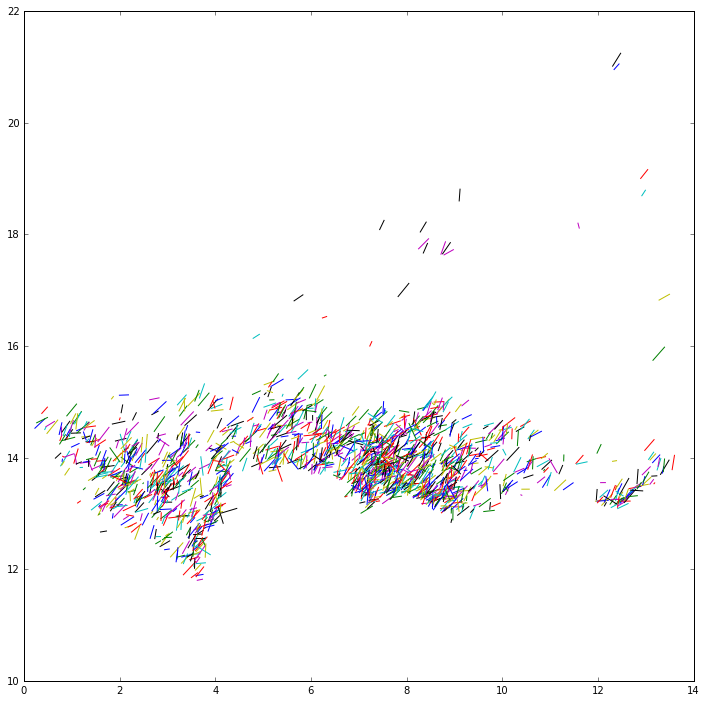

In [33]:
plt.figure(figsize=(12,12))
for i in range(len(dat_mod)) :
    line = dat_mod.iloc[i]
    if (line['dist_validation'] < 40) :
        long = [line['long'] , line['renaloc_longitude']] 
        lat = [line['lat'], line['renaloc_latitude']]
        plt.plot(long , lat )
plt.show()

In [117]:
test_dat.head()

,ID,osm_lat,osm_long,renaloc_lat,renaloc_long,renaloc_long_transformed,renaloc_lat_transformed
0,21361.0,14.526498,0.229299,14.693333,0.434167,-1.056241e+06,484.690010
1,21379.0,14.623800,0.265707,14.718611,0.491944,-1.056241e+06,484.715390
2,21420.0,14.791722,0.372899,14.904722,0.490278,-1.056241e+06,484.902252
3,21382.0,14.503155,0.435249,14.547778,0.460833,-1.056241e+06,484.543868
4,21366.0,14.555950,0.461909,14.648056,0.638611,-1.056241e+06,484.644550
